# **EMORY DATA: Transfusion Response Analysis with median SpO2, Hb, S/F (SpO2/FiO2), P/F (PaO2/FiO2) and blood volume (ml)**

**BeforeT: 24 hrs before T to T time, AfterT: T+4 hrs to T+4+$\tau$ hrs, where $\tau$=3,6,9,12**

find del_Hb, del_SpO2, S/F, P/F

Remove bed criteria to include more patients

In [1]:
import pandas as pd
from datetime import datetime
import os
import pickle
from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time
from dateutil.relativedelta import relativedelta
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np

import wfdb
from tqdm import tqdm

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import time

import warnings
warnings.filterwarnings('ignore') 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

**Adding CSNs into Patient Directory along with PAT_ID**

In [2]:
#years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
years = ['2016','2017','2018','2019','2020']

All_Vent_Pat_bed_matched_total = pd.DataFrame()
pat_total = 0
csn_total = 0

count=0
for year in years:
    bedFilePath = '/labs/kamaleswaranlab/MODS/Data/Emory_Data/em_data/'+str(year)+'/CJSEPSIS_BEDLOCATION_'+str(year)+'.dsv' #superset (all hospitalized patients)
    if not os.path.isfile(bedFilePath):
        print(f"Not in the path: {bedFilePath}")
        break
    else:
        bedPat = pd.read_csv(bedFilePath, sep='|')
        
        icuPat = bedPat[bedPat.accomodation_code=='ICU']
        
        #Linking all patients in list to vent dsv

        pat = len(icuPat['pat_id'].unique())
        csn = len(icuPat['csn'].unique())
        print(f'All total patients in {year}-- #pat_ids: {pat}, #CSNs: {csn}')
        pat_total = pat_total + pat
        csn_total = csn_total + csn
        
        icuPat['PAT_ID'] = icuPat['pat_id']
        icuPat['pat_id'] = icuPat['pat_id'].astype(str)

                 
        All_Vent_Pat_bed_matched = icuPat 
        
        All_Vent_Pat_bed_matched['year'] = str(year)
        
        #Creating a dataframe with all data pertaining to waveform identifiers from the list given
        
        All_Vent_Pat_bed_matched_total = pd.concat([All_Vent_Pat_bed_matched_total, All_Vent_Pat_bed_matched], axis=0)
        
print(f'Total patients throughout the years-- #pat_ids: {pat_total}, #CSNs: {csn_total}')
#debedWav = len(All_Vent_Pat_bed_matched_total['deBedTime'].unique())
patWav = len(All_Vent_Pat_bed_matched_total['PAT_ID'].unique())
csnWav = len(All_Vent_Pat_bed_matched_total['csn'].unique())
yrsWav = All_Vent_Pat_bed_matched_total['year'].unique()
print(f'Total patients admitted (no having waveforms criterion)-- #pat_ids: {patWav}, #CSNs: {csnWav}, #Years: {yrsWav}')

All total patients in 2016-- #pat_ids: 14008, #CSNs: 16194
All total patients in 2017-- #pat_ids: 13755, #CSNs: 15970
All total patients in 2018-- #pat_ids: 13967, #CSNs: 16262
All total patients in 2019-- #pat_ids: 15341, #CSNs: 17964
All total patients in 2020-- #pat_ids: 14418, #CSNs: 16377
Total patients throughout the years-- #pat_ids: 71489, #CSNs: 82767
Total patients admitted (no having waveforms criterion)-- #pat_ids: 64962, #CSNs: 82767, #Years: ['2016' '2017' '2018' '2019' '2020']


In [3]:
All_Vent_Pat_bed_matched_total.drop_duplicates(inplace=True)

In [4]:
# All_Vent_Pat_bed_matched_total['csn'] = All_Vent_Pat_bed_matched_total['csn'].astype('int64')
# All_Vent_Pat_bed_matched_total['csn']

In [1]:
# All_Vent_Pat_bed_matched_total

In [6]:
All_Vent_Pat_bed_matched_total=All_Vent_Pat_bed_matched_total.reset_index()

In [7]:
All_Vent_Pat_bed_matched_total.dtypes

index                        int64
pat_id                      object
csn                          int64
bed_location_start          object
bed_location_end            object
bed_unit                    object
bed_room                    object
bed_id                      object
bed_label                   object
hospital_service            object
accomodation_code           object
accomodation_description    object
PAT_ID                      object
year                        object
dtype: object

In [8]:
print(len(All_Vent_Pat_bed_matched_total.csn.unique()))
print(len(All_Vent_Pat_bed_matched_total.pat_id.unique()))

82767
64132


**Finding CSNs undergoes to Transfusion from Patient Directory**

In [9]:
df_transfusion = pd.read_excel('/labs/kamaleswaranlab/MODS/Transfusion/csns.annotated.redacted.volumes_included.xlsx', sheet_name='csns.annotated.redacted')
# pd.read_excel('/labs/kamaleswaranlab/MODS/Transfusion/csns.annotated.redacted.xlsx', sheet_name='csns.annotated')

In [10]:
df_transfusion.drop_duplicates(inplace=True)
df_transfusion.reset_index(drop=True, inplace=True)
df_transfusion

,no,csn,->,encntr_id,fin,product_id,dispense_dt_tm,estimated_transfusion_dt_tm,product_cd_disp,product_cat_cd_disp,orig_volume,cur_volume
0,580,666424005,->,77905080,666424005,712797,01/05/2014 16:54,01/05/2014 17:24,RBC CPD>AS1 LR 500,Red Cells,350.0,350.0
1,580,666424005,->,77905080,666424005,712802,01/05/2014 16:54,01/05/2014 17:24,RBC CPD>AS1 LR 500,Red Cells,350.0,350.0
2,580,666424005,->,77905080,666424005,734692,01/11/2014 16:08,01/11/2014 16:38,RBC CPD>AS1 LR 500,Red Cells,350.0,350.0
3,2506,4077473347,->,77358820,4077473347,700154,01/13/2014 12:37,01/13/2014 13:07,RBC CPD>AS1 LR 500,Red Cells,350.0,350.0
4,580,666424005,->,77905080,666424005,735660,01/15/2014 09:08,01/15/2014 09:38,RBC CPD>AS1 LR 500,Red Cells,350.0,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...
537821,565804,60508571340,->,200989762,60508571340,7266001,12/13/2021 03:27,12/13/2021 03:57,RBC CPD>AS1 LR Irr 500,Red Cells,350.0,350.0
537822,565804,60508571340,->,200989762,60508571340,7323997,12/13/2021 08:06,12/13/2021 08:36,Aph PLT ACDA LR PSORALEN 2 E8333,Platelet Pathogen Reduced,297.0,297.0
537823,565804,60508571340,->,200989762,60508571340,7328015,12/13/2021 11:17,12/13/2021 11:47,RBC CPD>AS1 LR Irr 500,Red Cells,350.0,350.0
537824,565804,60508571340,->,200989762,60508571340,7320033,12/13/2021 13:52,12/13/2021 14:22,Aph PLT ACDA>PAS-C LR PSORALEN 1 E8341,Platelet Pathogen Reduced,321.0,321.0


In [11]:
yearsT = np.arange(2014,2022)
print(f'How many years of patients bed-data present: {yearsT}')

# #How many years of waveform data
# yearsW = sorted((pd.to_datetime(All_Pat_file['DateStart']).dt.year).unique())
# print(f'How many years of waveform data present: {yearsW}')

yearsTrans = sorted((pd.to_datetime(df_transfusion['estimated_transfusion_dt_tm']).dt.year).unique())
print(f'How many years of transfusion data present: {yearsTrans}')

How many years of patients bed-data present: [2014 2015 2016 2017 2018 2019 2020 2021]
How many years of transfusion data present: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [12]:
df_transfusion['year'] = pd.to_datetime(df_transfusion['estimated_transfusion_dt_tm']).dt.year

In [13]:
df_transfusion['year'].unique()

array([2014, 2015, 2016, 2017, 2019, 2018, 2020, 2021, 2022])

In [14]:
from collections import Counter
w = Counter(df_transfusion.product_cat_cd_disp)

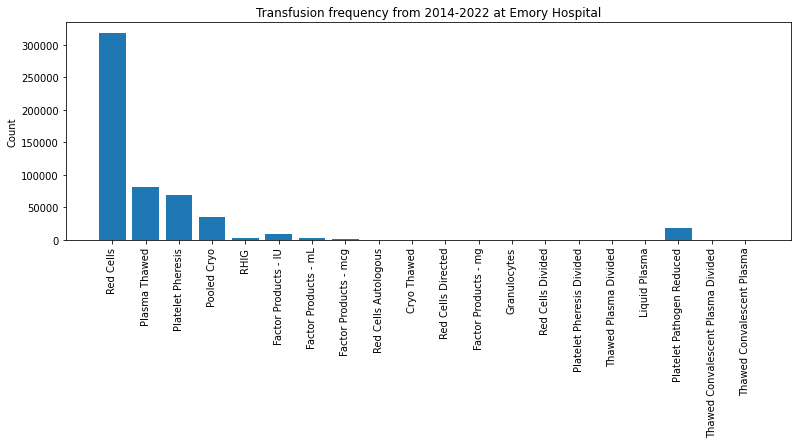

In [15]:
plt.figure(figsize=[13,4])
plt.bar(w.keys(), w.values())
y_pos = range(len(w.keys()))
# Rotation of the bars names
plt.xticks(y_pos, w.keys(), rotation=90)
plt.title('Transfusion frequency from 2014-2022 at Emory Hospital')
plt.ylabel('Count')
plt.show()

In [ ]:
df_transfusion_years = pd.DataFrame()
for yr in years:
    df_transfusion_y = df_transfusion[df_transfusion['year'] == int(yr)]
    df_transfusion_years = pd.concat([df_transfusion_years, df_transfusion_y], axis=0)
df_transfusion_years

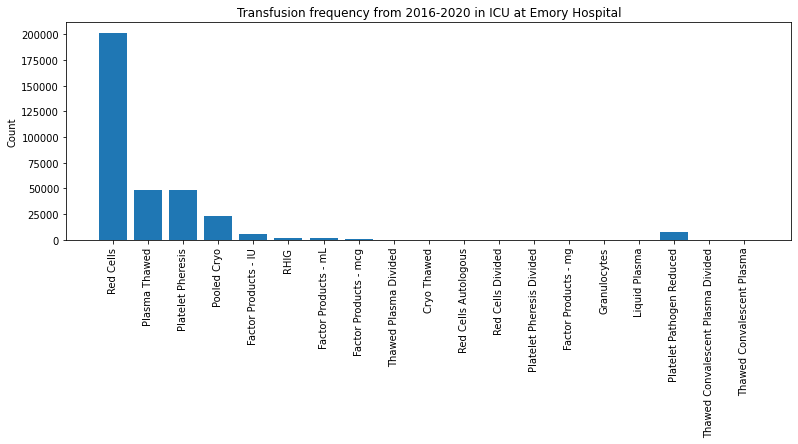

Counter({'Red Cells': 201845,
         'Plasma Thawed': 48182,
         'Platelet Pheresis': 48135,
         'Pooled Cryo': 23002,
         'Factor Products - IU': 5586,
         'RHIG': 1995,
         'Factor Products - mL': 1294,
         'Factor Products - mcg': 1047,
         'Thawed Plasma Divided': 129,
         'Cryo Thawed': 112,
         'Red Cells Autologous': 22,
         'Red Cells Divided': 82,
         'Platelet Pheresis Divided': 24,
         'Factor Products - mg': 8,
         'Granulocytes': 30,
         'Liquid Plasma': 46,
         'Platelet Pathogen Reduced': 7480,
         'Thawed Convalescent Plasma Divided': 50,
         'Thawed Convalescent Plasma': 11})

In [17]:
ww = Counter(df_transfusion_years.product_cat_cd_disp)
plt.figure(figsize=[13,4])
plt.bar(ww.keys(), ww.values())
y_pos = range(len(ww.keys()))
# Rotation of the bars names
plt.xticks(y_pos, ww.keys(), rotation=90)
plt.title('Transfusion frequency from 2016-2020 in ICU at Emory Hospital')
plt.ylabel('Count')
plt.show()
ww

### Find the matched patients

In [ ]:
df_transfusion_years.reset_index(drop=True, inplace=True)
df_transfusion_years

In [ ]:
All_csn_transfusion = All_Vent_Pat_bed_matched_total.merge(df_transfusion_years,on='csn',how='left') #Intersection
All_csn_transfusion

In [20]:
All_csn_transfusion['year'] = All_csn_transfusion['year_x']

In [21]:
All_csn_transfusion_new_selColumns0 = All_csn_transfusion[['pat_id','PAT_ID', 'csn', 'encntr_id',
       'dispense_dt_tm',  'estimated_transfusion_dt_tm', 'product_cd_disp','bed_location_start', 'bed_location_end',
       'product_cat_cd_disp','orig_volume','year','hospital_service']] 

In [22]:
### Remove columns with generated Nans from merging/matching process
print(All_csn_transfusion_new_selColumns0['estimated_transfusion_dt_tm'].isnull().sum())
print(All_csn_transfusion_new_selColumns0['dispense_dt_tm'].isnull().sum())
print(All_csn_transfusion_new_selColumns0['product_cat_cd_disp'].isnull().sum())

63965
63965
63965


In [ ]:
All_csn_transfusion_new = All_csn_transfusion_new_selColumns0[~(All_csn_transfusion_new_selColumns0['estimated_transfusion_dt_tm'].isnull())]
All_csn_transfusion_new.reset_index(drop=True, inplace=True)
All_csn_transfusion_new

In [24]:
print(All_csn_transfusion_new['estimated_transfusion_dt_tm'].isnull().sum())

0


In [25]:
All_csn_transfusion_new['orig_volume'].isna().sum()

5137

In [26]:
# debedWavT = len(All_csn_transfusion_new_selColumns0['deBedTime'].unique())
encountrWavT = len(All_csn_transfusion_new['encntr_id'].unique())
patWavT = len(All_csn_transfusion_new['PAT_ID'].unique())
csnWavT = len(All_csn_transfusion_new['csn'].unique())
yrsWavT = All_csn_transfusion_new['year'].unique()
print(f'Total patients transfused-- #pat_ids: {patWavT}, #CSNs: {csnWavT}, #encounterIDs: {encountrWavT}, #Years: {yrsWavT}')

Total patients transfused-- #pat_ids: 23209, #CSNs: 27015, #encounterIDs: 27015, #Years: ['2016' '2017' '2018' '2019' '2020']


### Focus on only Red cell transfusions

In [ ]:
All_csn_transfusion_new_RBC = All_csn_transfusion_new[All_csn_transfusion_new['product_cat_cd_disp']=='Red Cells']
All_csn_transfusion_new_RBC

In [28]:
All_csn_transfusion_new_RBC.reset_index(drop=True, inplace=True)

## Dicarding the patients with MTP showing bleeding/traumatic conditions 
> Greater than 3 transfusions in 6 hours

> **(a) Sort dataframe by csn sothat similar csn could be grouped, (b) check for each csn, whether it has repitions >3, (c) if it has, then check the timings if all are within 6 hrs window ---> discard this csn row entries completely**

In [ ]:
All_csn_transfusion_new_RBC2 = All_csn_transfusion_new_RBC.sort_values(by=['csn'])
All_csn_transfusion_new_RBC2.reset_index(drop=True, inplace=True)
All_csn_transfusion_new_RBC2

In [30]:
MTP_csns = np.array([],dtype=int)
unique_csns = All_csn_transfusion_new_RBC2['csn'].unique()
for i in tqdm(unique_csns):
    csn_count = list(All_csn_transfusion_new_RBC2['csn']).count(i)
    if csn_count >= 3:
        #print(csn_count)
        idx = np.where(np.array(All_csn_transfusion_new_RBC2['csn'])==i)[0]
        trans_times = pd.to_datetime(All_csn_transfusion_new_RBC2['estimated_transfusion_dt_tm'].iloc[idx]) 
        trans_times_sort = trans_times.sort_values().reset_index(drop=True)
        #print(trans_times_sort)
        diff_tt_sort = trans_times_sort.diff()
        Tcount_under_6hrs = (diff_tt_sort<pd.Timedelta(hours=6)).sum()
        if Tcount_under_6hrs >= 3:
            #print('MTP patient: discard it')
            MTP_csns = np.append(MTP_csns, i)
       
      
        
    

100%|██████████| 24506/24506 [35:35<00:00, 11.48it/s]


In [31]:
len(MTP_csns)

8608

> Discarding MTP csns by merging

In [32]:
MTP_csn_array=np.array([MTP_csns, MTP_csns+10000000000000]).T

In [ ]:
dfMTP_csns = pd.DataFrame(MTP_csn_array, index=np.arange(len(MTP_csn_array)), columns=['csn','arbitrary'])
dfMTP_csns

In [ ]:
All_csn_transfusion_new_RBC3 = All_csn_transfusion_new_RBC2.merge(dfMTP_csns,on='csn',how='left')#MTP_csns_series
All_csn_transfusion_new_RBC3

In [35]:
All_csn_transfusion_new_RBC3['arbitrary'].isnull()

0          True
1          True
2          True
3          True
4          True
          ...  
200908    False
200909    False
200910    False
200911     True
200912     True
Name: arbitrary, Length: 200913, dtype: bool

In [ ]:
All_csn_transfusion_new_RBC4 = All_csn_transfusion_new_RBC3[All_csn_transfusion_new_RBC3['arbitrary'].isnull()]
All_csn_transfusion_new_RBC4

In [37]:
IntersectionBeforeAfterT_RBC = All_csn_transfusion_new_RBC4

In [ ]:
IntersectionBeforeAfterT_RBC.drop_duplicates(inplace=True)
IntersectionBeforeAfterT_RBC.reset_index(drop=True, inplace=True)
IntersectionBeforeAfterT_RBC

In [39]:
#debedWavT3 = len(All_csndata_during_transfusion_list['deBedTime'].unique())
patWavT3 = len(IntersectionBeforeAfterT_RBC['PAT_ID'].unique())
csnWavT3 = len(IntersectionBeforeAfterT_RBC['csn'].unique())
yrsWavT3 = IntersectionBeforeAfterT_RBC['year'].unique()
print(f'Total patients having waveforms collected during transfusion-- #pat_ids: {patWavT3}, #CSNs: {csnWavT3}, #Years: {yrsWavT3}')

Total patients having waveforms collected during transfusion-- #pat_ids: 14113, #CSNs: 15898, #Years: ['2017' '2020' '2016' '2018' '2019']


In [40]:
print(bedPat.shape, All_Vent_Pat_bed_matched_total.shape, df_transfusion.shape, All_csn_transfusion_new.shape, IntersectionBeforeAfterT_RBC.shape)

(589813, 11) (101947, 14) (537826, 13) (374028, 13) (38765, 14)


In [41]:
IntersectionBeforeAfterT_RBC.drop_duplicates(inplace=True)
IntersectionBeforeAfterT_RBC.shape

(38765, 14)

In [42]:
#Remove redundency
IntersectionBeforeAfterT_RBC.drop_duplicates(subset=['pat_id', 'csn','estimated_transfusion_dt_tm'], keep='first', inplace=True)

In [43]:
IntersectionBeforeAfterT_RBC.drop(['arbitrary'], axis=1, inplace=True)

In [44]:
IntersectionBeforeAfterT_RBC.shape

(36276, 13)

In [ ]:
IntersectionBeforeT_RBC_sorted = IntersectionBeforeAfterT_RBC.sort_values(by=['csn'])
IntersectionBeforeT_RBC_sorted

## Exclude RBC Transfusions followed last 24 hours for a CSN

In [ ]:
x1 = IntersectionBeforeT_RBC_sorted[['csn','estimated_transfusion_dt_tm']]
x1

In [47]:
#exclude RBC Transfusions followed last 24 hours for a CSN

valid_Transf = pd.DataFrame([],columns=['csn','estimated_transfusion_dt_tm'])
csn_uni =x1.csn.unique()
for i, csnn in tqdm(enumerate(csn_uni)):
    idx = np.where(x1.csn == csnn)[0]
    TT=pd.to_datetime(x1.iloc[idx]['estimated_transfusion_dt_tm']).sort_values()
    dTT = TT.diff().dt.days
    Tsep = dTT < 1 #Trasfusion separation less than 1 day
    Tsep.iloc[0] = False
    z = np.where(~Tsep)[0] #Indexes need to save for csns and transfusions
    a = np.array([csnn]*len(z))
    b = TT.iloc[z].values
    z1 = pd.DataFrame([a,b],index=['csn','estimated_transfusion_dt_tm']).T
    valid_Transf = pd.concat([valid_Transf, z1],ignore_index=True)


15898it [01:19, 200.72it/s]


In [48]:
valid_Transf['Arb'] = 50
valid_Transf['csn'] = valid_Transf['csn'].astype(int)
valid_Transf['estimated_transfusion_dt_tm'] = pd.to_datetime(valid_Transf['estimated_transfusion_dt_tm'])

In [ ]:
IntersectionBeforeT_RBC_sorted['csn'] = IntersectionBeforeT_RBC_sorted['csn'].astype(int)
IntersectionBeforeT_RBC_sorted['estimated_transfusion_dt_tm'] = pd.to_datetime(IntersectionBeforeT_RBC_sorted['estimated_transfusion_dt_tm'])
IntersectionBeforeT_RBC_sorted1 = pd.merge(IntersectionBeforeT_RBC_sorted, valid_Transf, on=['csn','estimated_transfusion_dt_tm'],how='left')
IntersectionBeforeT_RBC_sorted2 = IntersectionBeforeT_RBC_sorted1[~IntersectionBeforeT_RBC_sorted1['Arb'].isnull()]
IntersectionBeforeT_RBC_sorted2.drop_duplicates(inplace=True)
IntersectionBeforeT_RBC_sorted2.reset_index(drop=True, inplace=True)
IntersectionBeforeT_RBC_sorted2

In [50]:
IntersectionBeforeT_RBC_sorted2.shape

(24802, 14)

## Add count of all product transfusions as a feature column in last 7 days

In [ ]:
all_transfusions = All_csn_transfusion_new[['csn','estimated_transfusion_dt_tm','product_cat_cd_disp']]
all_transfusions['estimated_transfusion_dt_tm'] = pd.to_datetime(all_transfusions['estimated_transfusion_dt_tm'])
all_transfusions['arbbb'] = 1000
all_transfusions.drop_duplicates(inplace=True)
all_transfusions.reset_index(drop=True, inplace=True)
all_transfusions

In [52]:
IntersectionBeforeT_RBC_sorted2['Tcount_7d'] = np.nan
for i in tqdm(range(IntersectionBeforeT_RBC_sorted2.shape[0])):
    est_TT =  IntersectionBeforeT_RBC_sorted2.iloc[i].estimated_transfusion_dt_tm
    csnn = IntersectionBeforeT_RBC_sorted2.iloc[i].csn
    
    all_TT_csnn = all_transfusions[all_transfusions.csn==csnn].estimated_transfusion_dt_tm
    Tdiff = est_TT - all_TT_csnn
    # Tdiffd = Tdiff.dt.days
    cond1 =  Tdiff>pd.Timedelta('0 days 00:00:00') 
    cond2 = Tdiff<pd.Timedelta('7 days 00:00:00')
    Tcount1 = (cond1 & cond2).sum()
    IntersectionBeforeT_RBC_sorted2['Tcount_7d'].iloc[i] = Tcount1
    
IntersectionBeforeT_RBC_sorted2['Tcount_7d'].isnull().sum()    
    
    

100%|██████████| 24802/24802 [10:29<00:00, 39.37it/s]


0

In [ ]:
IntersectionBeforeT_RBC_sorted2

In [54]:
IntersectionBeforeT_RBC_sorted2['year'] = IntersectionBeforeT_RBC_sorted2['year'].astype(int)

# Checkpoint 1: Save CSV

In [2]:
# IntersectionBeforeT_RBC_sorted2.to_csv('DATA_RESULTS/df_RBCT_beforeFeat_extraction_v3.csv')





# IntersectionBeforeT_RBC_sorted2 = pd.read_csv('DATA_RESULTS/df_RBCT_beforeFeat_extraction_v3.csv')

In [62]:
pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/em/'+str(2017)+'/'+str(15967048)+'.pickle'
with open(pkl_path, 'rb') as pf:
    patient_enc_dict = pickle.load(pf)
super_table = patient_enc_dict['super_table']

In [64]:
super_table["fio2"] = np.where(super_table["fio2"] < 0.33, 0.21, 0.32)

In [76]:
super_table


,temperature,daily_weight_kg,height_cm,sbp_line,dbp_line,map_line,sbp_cuff,dbp_cuff,map_cuff,pulse,...,procedure,best_map,norepinephrine_dose_weight,epinephrine_dose_weight,dobutamine_dose_weight,dopamine_dose_weight,phenylephrine_dose_weight,vasopressin_dose_weight,pf_sp,pf_pa
0,36.4,49.3,149.9,NaN,NaN,NaN,105.0,75.5,NaN,113.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.4,49.3,149.9,NaN,NaN,NaN,100.0,63.0,NaN,98.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.250,NaN
2,36.4,49.3,149.9,NaN,NaN,NaN,96.0,53.0,NaN,98.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.625,NaN
3,36.4,49.3,149.9,NaN,NaN,NaN,95.0,51.0,NaN,112.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.500,NaN
4,36.4,49.3,149.9,NaN,NaN,NaN,95.0,51.0,NaN,112.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,37.0,49.3,149.9,NaN,NaN,NaN,120.0,68.0,90.0,100.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528,36.3,49.3,149.9,NaN,NaN,NaN,123.0,72.0,93.0,79.0,...,0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529,36.3,49.3,149.9,NaN,NaN,NaN,123.0,72.0,93.0,79.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,36.3,49.3,149.9,NaN,NaN,NaN,123.0,72.0,93.0,79.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
super_table.index=np.arange(len(super_table))

In [68]:
super_table[super_table.fio2.values<0.30].fio2 = 0.11

In [74]:
super_table.fio2.loc[super_table.fio2<0.30] = 0.11

In [78]:
''' **Designed for EMORY data** 
Assumptions are: (i) T: Transfusion time = 4 hrs
Before T: 3-24 hrs
After T: T+4 to T+4+tau hrs, where tau = 9 
Include baseline Hb (as variable) just before the transfusion started'''


def vitalsign_feature_extract(csn, year, transT, tau, row_index): #tau = 6 # (in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for 3 consecutive windows
    
    #AllFeatureTable = pd.DataFrame([])


    ## Assessing super table
    pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/em/'+str(year)+'/'+str(csn)+'.pickle'
    with open(pkl_path, 'rb') as pf:
        patient_enc_dict = pickle.load(pf)
    super_table = patient_enc_dict['super_table']
    super_table['Time']=super_table.index
    
    super_table0 = super_table.pop('Time')
    super_table.insert(0, 'Time', super_table0) #First column is "Time" now [moved from last to first column]
    
    
    super_table.index=np.arange(len(super_table))
    super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
    #super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)
    
    super_table.fio2.loc[super_table.fio2<0.21]=0.21

    # SF_ratio = super_table['pf_sp']
    hemogb = super_table['hemoglobin']
    # PF_ratio = super_table['pf_pa']
    spo2 = super_table['spo2']
    fio2 = super_table['fio2']
    pao2 = super_table['partial_pressure_of_oxygen_(pao2)']

    if fio2.isnull().all():
        fio2 = 0.21
    else:
        fio2.fillna(method='ffill', limit=24, inplace=True)
        fio2.fillna(method='bfill', limit=24, inplace=True) 
        
    SF_ratio = spo2/fio2
    PF_ratio = pao2/fio2
    
    # super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
    # super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)
    
    
    #Get these measures for beforeT and afterT segments
    a = np.array((transT-super_table['Time']).dt.days)
    
    #Find the sign change to identify transfusion time
    id1=np.where(a>=0)
    beforeTid = id1[0][-1] #it will throw indexError if id1 is empty 
    id2=np.where(a<0)
    afterTid = id2[0][0] + 4  #Considering 4 hrs of transfusion duration
    
    #Inter-sample interval is 1 hr in super_table
    if beforeTid >= 23: 
        beforeT_Inds = np.arange(beforeTid-23, beforeTid+1)
        Hb_beforeT0 = hemogb[beforeT_Inds]
        SF_beforeT0 = SF_ratio[beforeT_Inds]
        PF_beforeT0 = PF_ratio[beforeT_Inds]
        spo2_beforeT0 = spo2[beforeT_Inds]

#         #Removal of NAN entries
        Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
#         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
#         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
#         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 
        
        med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
        med_SF_beforeT = SF_beforeT0.median()
        med_PF_beforeT = PF_beforeT0.median()
        med_spo2_beforeT = spo2_beforeT0.median()
        # print(('loop if '+str(row_index)+'->'+str(np.array(Hb_beforeT0))))
        if Hb_beforeT.empty:
            Hb = np.nan   ### Baseline Hb just before the transfusion started 
        else:
            Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 
        #print(SF_beforeT0) 
        #print(Hb_beforeT)
        # print(('loop if '+str(row_index)))

        my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
                                         'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])
        #my_table_BeforeT.reset_index(drop=True, inplace=True)
    elif beforeTid > 2 and beforeTid < 23: 
        # print(('loop elif'+str(row_index)))
        beforeT_Inds = np.arange(0, beforeTid+1)
        Hb_beforeT0 = hemogb[beforeT_Inds]
        SF_beforeT0 = SF_ratio[beforeT_Inds]
        PF_beforeT0 = PF_ratio[beforeT_Inds]
        spo2_beforeT0 = spo2[beforeT_Inds]
        
        #Removal of NAN entries
        Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
#         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
#         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
#         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

        med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
        med_SF_beforeT = SF_beforeT0.median()
        med_PF_beforeT = PF_beforeT0.median()
        med_spo2_beforeT = spo2_beforeT0.median()
        if Hb_beforeT.empty:
            Hb = np.nan   ### Baseline Hb just before the transfusion started 
        else:
            Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 

        
        #print(SF_beforeT0)         
        #print(Hb_beforeT)

        my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
                                         'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])                         
        #my_table_BeforeT.reset_index(drop=True, inplace=True)  
    else:
        my_table_BeforeT = []
        #print('Removed')
        # print(('loop else'+str(row_index)))
 
    #####-----------------------------------------
     
    

    med_Hb_afterT = []
    med_SF_afterT = []
    med_PF_afterT = []
    med_spo2_afterT = []
    for tauId in range(3):
        if afterTid+((tauId+1)*tau) <= len(hemogb): # for total tau hrs range post-transfusion
            #print('flag1') 
            afterT_Inds = np.arange(afterTid+(tauId*tau), afterTid+((tauId+1)*tau))
            Hb_afterT0 = hemogb[afterT_Inds]
            SF_afterT0 = SF_ratio[afterT_Inds]
            PF_afterT0 = PF_ratio[afterT_Inds]
            spo2_afterT0 = spo2[afterT_Inds]
            
            

            #Removal of NAN entries
#             Hb_afterT = Hb_beforeT0[~Hb_beforeT0.isnull()]               #Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
#             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
#             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
#             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

            med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
            med_SF_afterT.append(SF_afterT0.median())
            med_PF_afterT.append(PF_afterT0.median())
            med_spo2_afterT.append(spo2_afterT0.median())
            
        elif afterTid+((tauId+1)*tau) > len(hemogb) and afterTid+((tauId+1)*tau) <= len(hemogb)-3: # for atleast having 3 hrs range post-transfusion
            #print('flag2')
            afterT_Inds = np.arange(afterTid+(tauId*tau), len(hemogb))
            Hb_afterT0 = hemogb[afterT_Inds]
            SF_afterT0 = SF_ratio[afterT_Inds]
            PF_afterT0 = PF_ratio[afterT_Inds]
            spo2_afterT0 = spo2[afterT_Inds]
            
             

#             #Removal of NAN entries
#             Hb_afterT = Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
#             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
#             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
#             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

            med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
            med_SF_afterT.append(SF_afterT0.median())
            med_PF_afterT.append(PF_afterT0.median())
            med_spo2_afterT.append(spo2_afterT0.median())
            
        else:
            med_Hb_afterT.append(None)
            med_SF_afterT.append(None)
            med_PF_afterT.append(None)
            med_spo2_afterT.append(None)
            
        
        
       
    
    ######-------------------------------------
        
#     # Tracking missing data at the output (Trying to find the reason of csns reduction after this fun executed)
#     csn_yr_Ttime = str(csn)+'/'+str(year)+'/'+str(transT)
#     if len(my_table_BeforeT) == 0: 
#         BeforeT_no3hrsdata = csn_yr_Ttime
#     else: 
#         BeforeT_no3hrsdata = 0
#         if pd.isnull(med_Hb_beforeT): med_Hb_beforeT_missing=csn_yr_Ttime
#         else: med_Hb_beforeT_missing = 0

#         if pd.isnull(med_spo2_beforeT): med_spo2_beforeT_missing=csn_yr_Ttime 
#         else: med_spo2_beforeT_missing = 0

#         if pd.isnull(med_SF_beforeT): med_SF_beforeT_missing=csn_yr_Ttime 
#         else: med_SF_beforeT_missing = 0

#         if pd.isnull(med_PF_beforeT): med_PF_beforeT_missing=csn_yr_Ttime 
#         else: med_PF_beforeT_missing = 0

    
#     if all(pd.isnull(med_Hb_afterT)): med_Hb_afterT_all3missing=csn_yr_Ttime 
#     else: med_Hb_afterT_all3missing = 0
    
#     if all(pd.isnull(med_spo2_afterT)): med_spo2_afterT_all3missing=csn_yr_Ttime 
#     else: med_spo2_afterT_all3missing = 0
    
#     if all(pd.isnull(med_SF_afterT)): med_SF_afterT_all3missing=csn_yr_Ttime 
#     else: med_SF_afterT_all3missing = 0
    
#     if all(pd.isnull(med_PF_afterT)): med_PF_afterT_all3missing=csn_yr_Ttime
#     else: med_PF_afterT_all3missing = 0    
    
    
    #Discarding patient with no data present beforeT 3hrs window
    #and Discarding patient if all afterT features are empty (None/NaN) 
    Ls = len(my_table_BeforeT)
    if Ls>0: #and (not pd.isnull(med_Hb_beforeT)) and (not pd.isnull(med_spo2_beforeT)) and (not pd.isnull(med_SF_beforeT)) and (not pd.isnull(med_PF_beforeT)) and (not all(pd.isnull(med_Hb_afterT))) and (not all(pd.isnull(med_spo2_afterT))) and (not all(pd.isnull(med_SF_afterT))) and (not all(pd.isnull(med_PF_afterT))): 
        z = pd.DataFrame(IntersectionBeforeT_RBC_sorted2.iloc[row_index]).T
        z['discharge_to'] = patient_enc_dict['static_features']['discharge_to']
        z['age'] = patient_enc_dict['static_features']['age']
        z['gender'] = patient_enc_dict['static_features']['gender']
        z['race'] = patient_enc_dict['static_features']['race']
        z['ethnicity'] = patient_enc_dict['static_features']['ethnicity'] 
                
        z.reset_index(drop=True, inplace=True)
        my_table_BeforeT.reset_index(drop=True, inplace=True)
        my_table_BeforeT1 = pd.concat([z, my_table_BeforeT], axis=1)
        
        MSPO2_afterT1, MSPO2_afterT2, MSPO2_afterT3 = med_spo2_afterT
        MHB_afterT1, MHB_afterT2, MHB_afterT3 = med_Hb_afterT
        MSF_afterT1, MSF_afterT2, MSF_afterT3 = med_SF_afterT
        MPF_afterT1, MPF_afterT2, MPF_afterT3 = med_PF_afterT
        my_table_AfterT = pd.DataFrame({'MSPO2_afterT1':MSPO2_afterT1, 'MSPO2_afterT2':MSPO2_afterT2, 'MSPO2_afterT3': MSPO2_afterT3,
                                        'MHB_afterT1':MHB_afterT1, 'MHB_afterT2':MHB_afterT2, 'MHB_afterT3': MHB_afterT3,
                                        'MSF_afterT1':MSF_afterT1, 'MSF_afterT2':MSF_afterT2, 'MSF_afterT3': MSF_afterT3,
                                        'MPF_afterT1':MPF_afterT1, 'MPF_afterT2':MPF_afterT2, 'MPF_afterT3': MPF_afterT3
                                       }, index=[0])                         
        my_table_BeforeT1.reset_index(drop=True, inplace=True)
        my_table_AfterT.reset_index(drop=True, inplace=True)
        my_table_BeforeAfterT = pd.concat([my_table_BeforeT1, my_table_AfterT], axis=1)

        #AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
        total_eleminated = 0
    else:
        my_table_BeforeAfterT = []
        #total_eleminated = csn_yr_Ttime
        
        
    
    # missingD = pd.DataFrame({'total_eleminated':total_eleminated, 'BeforeT_no3hrsdata': BeforeT_no3hrsdata,
    #                          'med_Hb_beforeT_missing': med_Hb_beforeT_missing})

    return my_table_BeforeAfterT #, missingD
        # Hb, med_spo2_beforeT,\
        # med_Hb_beforeT, med_SF_beforeT, med_PF_beforeT, med_spo2_afterT, med_Hb_afterT, med_SF_afterT, med_PF_afterT


In [54]:
# ''' **Designed for EMORY data** 
# Assumptions are: (i) T: Transfusion time = 4 hrs
# Before T: 3-24 hrs
# After T: T+4 to T+4+tau hrs, where tau = 9 
# Include baseline Hb (as variable) just before the transfusion started'''


# def vitalsign_feature_extract(csn, year, transT, tau, row_index): #tau = 6 # (in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for 3 consecutive windows
    
#     #AllFeatureTable = pd.DataFrame([])


#     ## Assessing super table
#     pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/em/'+str(year)+'/'+str(csn)+'.pickle'
#     with open(pkl_path, 'rb') as pf:
#         patient_enc_dict = pickle.load(pf)
#     super_table = patient_enc_dict['super_table']
#     super_table['Time']=super_table.index
    
#     super_table0 = super_table.pop('Time')
#     super_table.insert(0, 'Time', super_table0) #First column is "Time" now [moved from last to first column]
    
#     super_table.index=np.arange(len(super_table))
#     super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
#     #super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)

#     SF_ratio = super_table['pf_sp']
#     hemogb = super_table['hemoglobin']
#     PF_ratio = super_table['pf_pa']
#     spo2 = super_table['spo2']

#     #Get these measures for beforeT and afterT segments
#     a = np.array((transT-super_table['Time']).dt.days)
    

#     #Find the sign change to identify transfusion time
#     id1=np.where(a>=0)
#     beforeTid = id1[0][-1]
#     id2=np.where(a<0)
#     afterTid = id2[0][0] + 4  #Considering 4 hrs of transfusion duration
    
#     #Inter-sample interval is 1 hr in super_table
#     if beforeTid >= 23: 
#         beforeT_Inds = np.arange(beforeTid-23, beforeTid+1)
#         Hb_beforeT0 = hemogb[beforeT_Inds]
#         SF_beforeT0 = SF_ratio[beforeT_Inds]
#         PF_beforeT0 = PF_ratio[beforeT_Inds]
#         spo2_beforeT0 = spo2[beforeT_Inds]

# #         #Removal of NAN entries
#         Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
# #         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
# #         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
# #         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

#         med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
#         med_SF_beforeT = SF_beforeT0.median()
#         med_PF_beforeT = PF_beforeT0.median()
#         med_spo2_beforeT = spo2_beforeT0.median()
#         Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 
#         #print(SF_beforeT0) 
        
#         #print(Hb_beforeT)

#         my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
#                                          'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])
#         #my_table_BeforeT.reset_index(drop=True, inplace=True)
#     elif beforeTid > 2 and beforeTid < 23: 
#         beforeT_Inds = np.arange(0, beforeTid+1)
#         Hb_beforeT0 = hemogb[beforeT_Inds]
#         SF_beforeT0 = SF_ratio[beforeT_Inds]
#         PF_beforeT0 = PF_ratio[beforeT_Inds]
#         spo2_beforeT0 = spo2[beforeT_Inds]
        
#         #Removal of NAN entries
#         Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
# #         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
# #         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
# #         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

#         med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
#         med_SF_beforeT = SF_beforeT0.median()
#         med_PF_beforeT = PF_beforeT0.median()
#         med_spo2_beforeT = spo2_beforeT0.median()
#         Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 

        
#         #print(SF_beforeT0) 
        
#         #print(Hb_beforeT)

#         my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
#                                          'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])                         
#         #my_table_BeforeT.reset_index(drop=True, inplace=True)                                 
#     else:
#         my_table_BeforeT = []
#         #print('Removed')
 
#     #####-----------------------------------------
     
   

#     med_Hb_afterT = []
#     med_SF_afterT = []
#     med_PF_afterT = []
#     med_spo2_afterT = []
#     for tauId in range(3):
#         if afterTid+((tauId+1)*tau) <= len(hemogb): # for total tau hrs range post-transfusion
#             #print('flag1') 
#             afterT_Inds = np.arange(afterTid+(tauId*tau), afterTid+((tauId+1)*tau))
#             Hb_afterT0 = hemogb[afterT_Inds]
#             SF_afterT0 = SF_ratio[afterT_Inds]
#             PF_afterT0 = PF_ratio[afterT_Inds]
#             spo2_afterT0 = spo2[afterT_Inds]
            
            

#             #Removal of NAN entries
# #             Hb_afterT = Hb_beforeT0[~Hb_beforeT0.isnull()]               #Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
# #             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
# #             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
# #             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

#             med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
#             med_SF_afterT.append(SF_afterT0.median())
#             med_PF_afterT.append(PF_afterT0.median())
#             med_spo2_afterT.append(spo2_afterT0.median())
            
#         elif afterTid+((tauId+1)*tau) > len(hemogb) and afterTid+((tauId+1)*tau) <= len(hemogb)-3: # for atleast having 3 hrs range post-transfusion
#             #print('flag2')
#             afterT_Inds = np.arange(afterTid+(tauId*tau), len(hemogb))
#             Hb_afterT0 = hemogb[afterT_Inds]
#             SF_afterT0 = SF_ratio[afterT_Inds]
#             PF_afterT0 = PF_ratio[afterT_Inds]
#             spo2_afterT0 = spo2[afterT_Inds]
            
             

# #             #Removal of NAN entries
# #             Hb_afterT = Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
# #             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
# #             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
# #             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

#             med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
#             med_SF_afterT.append(SF_afterT0.median())
#             med_PF_afterT.append(PF_afterT0.median())
#             med_spo2_afterT.append(spo2_afterT0.median())
            
#         else:
#             med_Hb_afterT.append(None)
#             med_SF_afterT.append(None)
#             med_PF_afterT.append(None)
#             med_spo2_afterT.append(None)
            
        
        
       
    
#     ######-------------------------------------
        
# #     # Tracking missing data at the output (Trying to find the reason of csns reduction after this fun executed)
# #     csn_yr_Ttime = str(csn)+'/'+str(year)+'/'+str(transT)
# #     if len(my_table_BeforeT) == 0: 
# #         BeforeT_no3hrsdata = csn_yr_Ttime
# #     else: 
# #         BeforeT_no3hrsdata = 0
# #         if pd.isnull(med_Hb_beforeT): med_Hb_beforeT_missing=csn_yr_Ttime
# #         else: med_Hb_beforeT_missing = 0

# #         if pd.isnull(med_spo2_beforeT): med_spo2_beforeT_missing=csn_yr_Ttime 
# #         else: med_spo2_beforeT_missing = 0

# #         if pd.isnull(med_SF_beforeT): med_SF_beforeT_missing=csn_yr_Ttime 
# #         else: med_SF_beforeT_missing = 0

# #         if pd.isnull(med_PF_beforeT): med_PF_beforeT_missing=csn_yr_Ttime 
# #         else: med_PF_beforeT_missing = 0

    
# #     if all(pd.isnull(med_Hb_afterT)): med_Hb_afterT_all3missing=csn_yr_Ttime 
# #     else: med_Hb_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_spo2_afterT)): med_spo2_afterT_all3missing=csn_yr_Ttime 
# #     else: med_spo2_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_SF_afterT)): med_SF_afterT_all3missing=csn_yr_Ttime 
# #     else: med_SF_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_PF_afterT)): med_PF_afterT_all3missing=csn_yr_Ttime
# #     else: med_PF_afterT_all3missing = 0    
    
    
#     #Discarding patient with no data present beforeT 3hrs window
#     #and Discarding patient if all afterT features are empty (None/NaN) 
#     Ls = len(my_table_BeforeT)
#     if Ls>0 and (not pd.isnull(med_Hb_beforeT)) and (not pd.isnull(med_spo2_beforeT)) and (not pd.isnull(med_SF_beforeT)) and (not pd.isnull(med_PF_beforeT)) and (not all(pd.isnull(med_Hb_afterT))) and (not all(pd.isnull(med_spo2_afterT))) and (not all(pd.isnull(med_SF_afterT))) and (not all(pd.isnull(med_PF_afterT))): 
#         z = pd.DataFrame(IntersectionBeforeT_RBC_sorted2.iloc[row_index]).T
#         z['discharge_to'] = patient_enc_dict['static_features']['discharge_to']
#         z['age'] = patient_enc_dict['static_features']['age']
#         z['gender'] = patient_enc_dict['static_features']['gender']
#         z['race'] = patient_enc_dict['static_features']['race']
#         z['ethnicity'] = patient_enc_dict['static_features']['ethnicity'] 
                
#         z.reset_index(drop=True, inplace=True)
#         my_table_BeforeT.reset_index(drop=True, inplace=True)
#         my_table_BeforeT1 = pd.concat([z, my_table_BeforeT], axis=1)
        
#         MSPO2_afterT1, MSPO2_afterT2, MSPO2_afterT3 = med_spo2_afterT
#         MHB_afterT1, MHB_afterT2, MHB_afterT3 = med_Hb_afterT
#         MSF_afterT1, MSF_afterT2, MSF_afterT3 = med_SF_afterT
#         MPF_afterT1, MPF_afterT2, MPF_afterT3 = med_PF_afterT
#         my_table_AfterT = pd.DataFrame({'MSPO2_afterT1':MSPO2_afterT1, 'MSPO2_afterT2':MSPO2_afterT2, 'MSPO2_afterT3': MSPO2_afterT3,
#                                         'MHB_afterT1':MHB_afterT1, 'MHB_afterT2':MHB_afterT2, 'MHB_afterT3': MHB_afterT3,
#                                         'MSF_afterT1':MSF_afterT1, 'MSF_afterT2':MSF_afterT2, 'MSF_afterT3': MSF_afterT3,
#                                         'MPF_afterT1':MPF_afterT1, 'MPF_afterT2':MPF_afterT2, 'MPF_afterT3': MPF_afterT3
#                                        }, index=[0])                         
#         my_table_BeforeT1.reset_index(drop=True, inplace=True)
#         my_table_AfterT.reset_index(drop=True, inplace=True)
#         my_table_BeforeAfterT = pd.concat([my_table_BeforeT1, my_table_AfterT], axis=1)

#         #AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
#         total_eleminated = 0
#     else:
#         my_table_BeforeAfterT = []
#         #total_eleminated = csn_yr_Ttime
        
        
    
#     # missingD = pd.DataFrame({'total_eleminated':total_eleminated, 'BeforeT_no3hrsdata': BeforeT_no3hrsdata,
#     #                          'med_Hb_beforeT_missing': med_Hb_beforeT_missing})

#     return my_table_BeforeAfterT #, missingD
#         # Hb, med_spo2_beforeT,\
#         # med_Hb_beforeT, med_SF_beforeT, med_PF_beforeT, med_spo2_afterT, med_Hb_afterT, med_SF_afterT, med_PF_afterT


In [79]:
tau = 9 #int(input('Enter tau = ')) #(in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for three consecutive windows

L = len(IntersectionBeforeT_RBC_sorted2)
print(L)

24802


In [80]:
##Using Parallelization: Multiprocessing

t1 = time.time()
def f1(i):
    #for i,csn in tqdm(enumerate(IntersectionBeforeDuringAfter_RBC['csn'] )):  #.iloc[:3]
    AllFeatureTable = pd.DataFrame([])
    missingdata = pd.DataFrame([])
    try: 
        transT = pd.to_datetime(IntersectionBeforeT_RBC_sorted2.iloc[i]['estimated_transfusion_dt_tm'])
        year = pd.to_datetime(IntersectionBeforeT_RBC_sorted2.iloc[i]['estimated_transfusion_dt_tm']).year #dt.year
        csn = IntersectionBeforeT_RBC_sorted2.iloc[i]['csn']
        

        my_table_BeforeAfterT = vitalsign_feature_extract(csn, year, transT, tau, row_index=i) #, missingD
        #print(AllFeatureTable)
        
        # print(('try '+str(i)))
        
        AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
        #missingdata.append(missingD)
            
    except IndexError:
        # print(('IndexError '+str(i)))
        pass
        #IndexErrorCases.append(i) #Record number
    except ValueError:
        # print(('ValueError '+str(i)))
        pass
        #ValueErrorCases.append(i)
    except FileNotFoundError:
        # print(('FileNotFoundError '+str(i)))
        pass
    except EOFError:
        print(('EOFerror '+str(i)))
        pass
        #FileNotFoundErrorCases.append(i)
    except pickle.UnpicklingError:
        print(('UnpicklingError '+str(i)))
        pass
    # except TypeError:
    #     print('TypeError')
    #     pass
    
    return AllFeatureTable #, missingdata


p1 = Pool(12)

# LLL=[0, 1, 2, 3, 4, 5, 19679, 18067, 19189, 20703]
results1 = p1.map(f1, range(L))  #range(L)
# results1, DF2 = zip(*p1.map(f1, range(10)))  #range(L)
p1.close()
p1.join()        
medianAllFeatureTable = pd.concat(results1, ignore_index=True)
# missing_Data = pd.concat(DF2, ignore_index=True)
t2 = time.time()
print('Completed in: %s sec'%(t2 - t1)) 


UnpicklingError 6781
Completed in: 330.71142077445984 sec


In [82]:
medianAllFeatureTable.columns

Index(['Unnamed: 0', 'pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3'],
      dtype='object')

# Checkpoint 2: Save CSV

In [2]:
# medianAllFeatureTable.to_csv('DATA_RESULTS/df_RBCT_extractedFeat_NoImputation_tau9_v3.csv')







# medianAllFeatureTable = pd.read_csv('DATA_RESULTS/df_RBCT_extractedFeat_NoImputation_tau9_v3.csv')

In [8]:
medianAllFeatureTable.loc[:,'Hb':].isnull().sum()

Hb                   2278
med_spo2_beforeT      117
med_Hb_beforeT       2278
med_SF_beforeT       4158
med_PF_beforeT      15764
MSPO2_afterT1         705
MSPO2_afterT2        1188
MSPO2_afterT3        1958
MHB_afterT1          2798
MHB_afterT2          3267
MHB_afterT3          4027
MSF_afterT1          5275
MSF_afterT2          5928
MSF_afterT3          6724
MPF_afterT1         16622
MPF_afterT2         17004
MPF_afterT3         17720
dtype: int64

In [9]:
medianAllFeatureTable.dtypes

Unnamed: 0                      object
pat_id                          object
PAT_ID                          object
csn                             object
encntr_id                       object
dispense_dt_tm                  object
estimated_transfusion_dt_tm     object
product_cd_disp                 object
bed_location_start              object
bed_location_end                object
product_cat_cd_disp             object
orig_volume                     object
year                            object
hospital_service                object
Arb                             object
Tcount_7d                       object
discharge_to                    object
age                              int64
gender                          object
race                            object
ethnicity                       object
Hb                             float64
med_spo2_beforeT               float64
med_Hb_beforeT                 float64
med_SF_beforeT                 float64
med_PF_beforeT           

In [281]:
# del medianAllFeatureTable

In [85]:
'''
Missing values (%)
'''
for i in medianAllFeatureTable.columns:
    print(i, medianAllFeatureTable[i].isnull().sum()) #/medianAllFeatureTable.shape[0]*100)

Unnamed: 0 0
pat_id 0
PAT_ID 0
csn 0
encntr_id 0
dispense_dt_tm 0
estimated_transfusion_dt_tm 0
product_cd_disp 0
bed_location_start 0
bed_location_end 0
product_cat_cd_disp 0
orig_volume 0
year 0
hospital_service 0
Arb 0
Tcount_7d 0
discharge_to 0
age 0
gender 0
race 0
ethnicity 0
Hb 2278
med_spo2_beforeT 117
med_Hb_beforeT 2278
med_SF_beforeT 4158
med_PF_beforeT 15764
MSPO2_afterT1 705
MSPO2_afterT2 1188
MSPO2_afterT3 1958
MHB_afterT1 2798
MHB_afterT2 3267
MHB_afterT3 4027
MSF_afterT1 5275
MSF_afterT2 5928
MSF_afterT3 6724
MPF_afterT1 16622
MPF_afterT2 17004
MPF_afterT3 17720


In [86]:
# fio2.fillna(method='ffill', limit=24, inplace=True)
medI_medianAllFeatureTable = medianAllFeatureTable.copy()
indx = list(medI_medianAllFeatureTable.columns).index('Hb')
for k in tqdm(range(indx,len(medI_medianAllFeatureTable.columns))):
    medI_medianAllFeatureTable.iloc[:,k].fillna(medI_medianAllFeatureTable.iloc[:,k].median(), inplace=True)

100%|██████████| 17/17 [00:00<00:00, 160.26it/s]


In [87]:
for i in medI_medianAllFeatureTable.columns:
    print(i, medI_medianAllFeatureTable[i].isnull().sum())#/medI_medianAllFeatureTable.shape[0])

Unnamed: 0 0
pat_id 0
PAT_ID 0
csn 0
encntr_id 0
dispense_dt_tm 0
estimated_transfusion_dt_tm 0
product_cd_disp 0
bed_location_start 0
bed_location_end 0
product_cat_cd_disp 0
orig_volume 0
year 0
hospital_service 0
Arb 0
Tcount_7d 0
discharge_to 0
age 0
gender 0
race 0
ethnicity 0
Hb 0
med_spo2_beforeT 117
med_Hb_beforeT 2278
med_SF_beforeT 4158
med_PF_beforeT 15764
MSPO2_afterT1 0
MSPO2_afterT2 0
MSPO2_afterT3 0
MHB_afterT1 0
MHB_afterT2 0
MHB_afterT3 0
MSF_afterT1 0
MSF_afterT2 0
MSF_afterT3 0
MPF_afterT1 0
MPF_afterT2 0
MPF_afterT3 0


In [88]:
medI_medianAllFeatureTable[medI_medianAllFeatureTable.med_spo2_beforeT.isnull()].med_spo2_beforeT

596      98.0
1350     98.0
1720     98.0
1920     98.0
1996     98.0
         ... 
21668    98.0
21714    98.0
21888    98.0
21986    98.0
22803    98.0
Name: med_spo2_beforeT, Length: 117, dtype: float64

In [ ]:
medI_medianAllFeatureTable

In [90]:
def delta_calc(df):
    df['del_SPO2_1']=df['MSPO2_afterT1'] - df['med_spo2_beforeT']
    df['del_SPO2_2']=df['MSPO2_afterT2'] - df['med_spo2_beforeT']
    df['del_SPO2_3']=df['MSPO2_afterT3'] - df['med_spo2_beforeT']

    df['del_Hb_1']=df['MHB_afterT1'] - df['med_Hb_beforeT']
    df['del_Hb_2']=df['MHB_afterT2'] - df['med_Hb_beforeT']
    df['del_Hb_3']=df['MHB_afterT3'] - df['med_Hb_beforeT']

    df['del_SF_1']=df['MSF_afterT1'] - df['med_SF_beforeT']
    df['del_SF_2']=df['MSF_afterT2'] - df['med_SF_beforeT']
    df['del_SF_3']=df['MSF_afterT3'] - df['med_SF_beforeT']

    df['del_PF_1']=df['MPF_afterT1'] - df['med_PF_beforeT']
    df['del_PF_2']=df['MPF_afterT2'] - df['med_PF_beforeT']
    df['del_PF_3']=df['MPF_afterT3'] - df['med_PF_beforeT']
    return df

In [92]:
medianAllFeatureTable = delta_calc(medianAllFeatureTable)

In [93]:
medI_medianAllFeatureTable = delta_calc(medI_medianAllFeatureTable)

In [94]:
medI_medianAllFeatureTable.shape

(22874, 50)

In [95]:
len(medI_medianAllFeatureTable['csn'].unique())

14765

In [96]:
len(medI_medianAllFeatureTable['PAT_ID'].unique())

13051

# Checkpoint 3: **writing in CSV**

In [2]:
# #writing in CSV
# medI_medianAllFeatureTable.to_csv('DATA_RESULTS/df_RBCT_extractedFeat_medImputated_tau9_v3.csv')
# medianAllFeatureTable.to_csv('DATA_RESULTS/df_RBCT_extractedFeat_NoImputated_tau9_v3.csv')









medianAllFeatureTable = pd.read_csv('DATA_RESULTS/df_RBCT_extractedFeat_NoImputated_tau9_v3.csv')

In [4]:
medianAllFeatureTable.shape, len(medianAllFeatureTable.csn.unique()), len(medianAllFeatureTable.pat_id.unique())

((22874, 52), 14765, 13051)

Text(0, 0.5, 'AfterT3 $\\Delta$Hb (g/dL)')

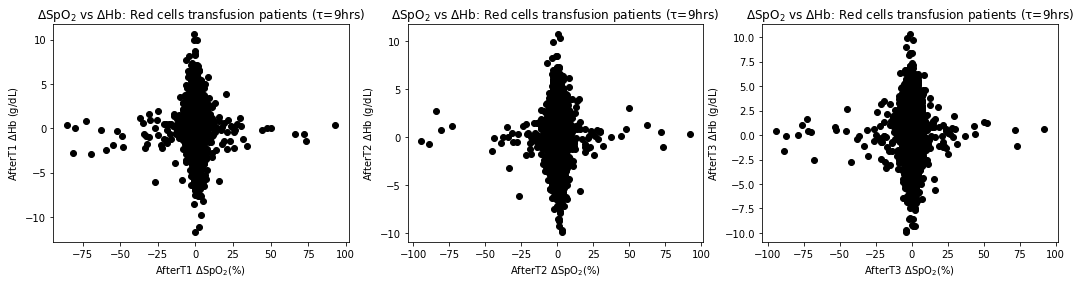

In [98]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medI_medianAllFeatureTable['del_SPO2_1'], medI_medianAllFeatureTable['del_Hb_1'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('AfterT1 $\Delta$Hb (g/dL)')

axs[1].scatter(medI_medianAllFeatureTable['del_SPO2_2'], medI_medianAllFeatureTable['del_Hb_2'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('AfterT2 $\Delta$Hb (g/dL)')

axs[2].scatter(medI_medianAllFeatureTable['del_SPO2_3'], medI_medianAllFeatureTable['del_Hb_3'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('AfterT3 $\Delta$Hb (g/dL)')

# plt.savefig("DATA_RESULTS/delSpO2vsdelHb_RedCellsT.eps", format="eps", bbox_inches="tight", dpi=300)


Text(0, 0.5, 'Hb (g/dL) just before transfusion')

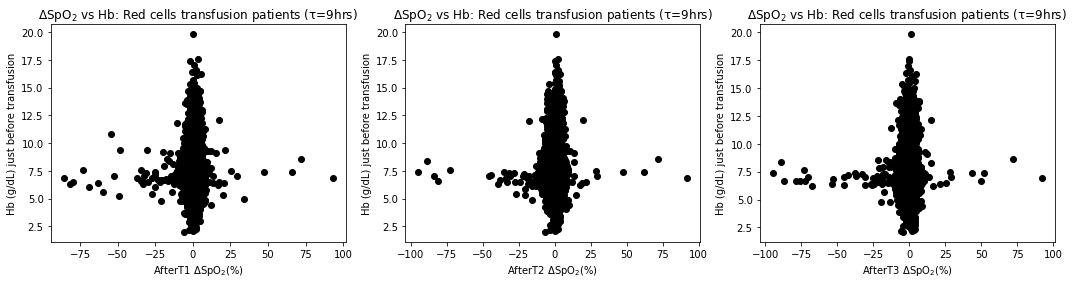

In [99]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['Hb'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('Hb (g/dL) just before transfusion')

axs[1].scatter(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['Hb'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('Hb (g/dL) just before transfusion')

axs[2].scatter(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['Hb'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('Hb (g/dL) just before transfusion')

# plt.savefig('DATA_RESULTS/delSpO2vsHb_RedCellsT.png', format="png", bbox_inches="tight", dpi=300)

In [ ]:
fig, axs = plt.subplots(figsize =(6, 4))

axs.plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['Hb'],'o',color='black')
axs.plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['Hb'],'o',color='red')
axs.plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['Hb'],'o',color='blue')
axs.set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs.set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs.set_ylabel('Hb (g/dL) just before transfusion')
axs.legend(['afterT1 $\Delta$SpO2 vs Hb','afterT2 $\Delta$SpO2 vs Hb','afterT3 $\Delta$SpO2 vs Hb'])

# plt.savefig('DATA_RESULTS/ThreeRegions_delSpO2vsHb_RedCellsT.eps', format="eps", bbox_inches="tight", dpi=300)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_1'],'o',color='black')
axs[0].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_1'],'o',color='red')
axs[0].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_1'],'o',color='blue')
axs[0].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[0].set_ylabel('AfterT1 $\Delta$Hb (g/dL)')
axs[0].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb1','afterT2 $\Delta$SpO2 vs $\Delta$Hb1','afterT3 $\Delta$SpO2 vs $\Delta$Hb1'])
axs[0].set_ylim([-5,9])

axs[1].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_2'],'o',color='black')
axs[1].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_2'],'o',color='red')
axs[1].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_2'],'o',color='blue')
axs[1].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[1].set_ylabel('AfterT2 $\Delta$Hb (g/dL)')
axs[1].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb2','afterT2 $\Delta$SpO2 vs $\Delta$Hb2','afterT3 $\Delta$SpO2 vs $\Delta$Hb2'])
axs[1].set_ylim([-5,9])

axs[2].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_3'],'o',color='black')
axs[2].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_3'],'o',color='red')
axs[2].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_3'],'o',color='blue')
axs[2].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[2].set_ylabel('AfterT3 $\Delta$Hb (g/dL)')
axs[2].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb3','afterT2 $\Delta$SpO2 vs $\Delta$Hb3','afterT3 $\Delta$SpO2 vs $\Delta$Hb3'])
axs[2].set_ylim([-5,9])

# plt.savefig('DATA_RESULTS/ThreeRegions_delSpO2vsdelHb_RedCellsT_7_24_22.png')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MHB_afterT1'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median HB afterT1')
axs[0].set_ylabel('Median HB beforeT')

axs[1].scatter(medianAllFeatureTable['MHB_afterT2'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median HB afterT2')
axs[1].set_ylabel('Median HB beforeT')

axs[2].scatter(medianAllFeatureTable['MHB_afterT3'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median HB afterT3')
axs[2].set_ylabel('Median HB beforeT')

# plt.savefig('DATA_RESULTS/Hb_BeforeAndAfterT_RedCellsT_7_24_22.png')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MSF_afterT1'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median SF afterT1')
axs[0].set_ylabel('Median SF beforeT')

axs[1].scatter(medianAllFeatureTable['MSF_afterT2'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median SF afterT2')
axs[1].set_ylabel('Median SF beforeT')

axs[2].scatter(medianAllFeatureTable['MSF_afterT3'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median SF afterT3')
axs[2].set_ylabel('Median SF beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/SF_BeforeAndAfterT_RedCellsT_6_23_22.png')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MPF_afterT1'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median PF afterT1')
axs[0].set_ylabel('Median PF beforeT')

axs[1].scatter(medianAllFeatureTable['MPF_afterT2'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median PF afterT2')
axs[1].set_ylabel('Median PF beforeT')

axs[2].scatter(medianAllFeatureTable['MPF_afterT3'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median PF afterT3')
axs[2].set_ylabel('Median PF beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/PF_BeforeAndAfterT_RedCellsT_6_23_22.png')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MSPO2_afterT1'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median SpO2 afterT1')
axs[0].set_ylabel('Median SpO2 beforeT')

axs[1].scatter(medianAllFeatureTable['MSPO2_afterT2'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median SpO2 afterT2')
axs[1].set_ylabel('Median SpO2 beforeT')

axs[2].scatter(medianAllFeatureTable['MSPO2_afterT3'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median SpO2 afterT3')
axs[2].set_ylabel('Median SpO2 beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/SpO2_BeforeAndAfterT_RedCellsT_6_23_22.png')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['orig_volume'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('Hb (g/dL) just before transfusion')

axs[1].scatter(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['orig_volume'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('Transfused blood volume (ml)')

axs[2].scatter(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['orig_volume'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('Transfused blood volume (ml)')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/delSpO2vsBloodV_RedCellsT_6_23_22.png')

In [ ]:
fig, axs = plt.subplots()

axs.scatter(medianAllFeatureTable['Hb'], medianAllFeatureTable['orig_volume'],color='black')
axs.set_title('Hb vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs.set_xlabel('Hb (g/dL) just before transfusion')
axs.set_ylabel('Blood volume (ml)')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/HbvsBloodV_RedCellsT_6_23_22.png')

In [ ]:
len(ResponderIndex)

In [ ]:
len(NonResponderIndex)

In [ ]:
len(FileNotFoundErrorCases)

In [ ]:
len(np.unique(ResponderList))

In [ ]:
len(np.unique(NonResponderList))

In [ ]:
len(IndexErrorCases)

In [ ]:
len(ValueErrorCases)

In [ ]:
len(LenLessThan24HrIndexAfterT)

In [ ]:
len(LenLessThan24HrIndexBeforeT)

In [ ]:
len(ErrorLessThan5HrAfterTtime)

In [ ]:
#len(GoodSpO2CasesBeforeT)

In [ ]:
TransfusionVar = {'ResponderIndex': ResponderIndex, 'NonResponderIndex': NonResponderIndex, 
                 'ResponderList': ResponderList, 'NonResponderList': NonResponderList,
                 'FileNotFoundErrorCases': FileNotFoundErrorCases, 'IndexErrorCases': IndexErrorCases,
                 'ValueErrorCases': ValueErrorCases, 'LenLessThan24HrIndexAfterT': LenLessThan24HrIndexAfterT,
                 'LenLessThan24HrIndexBeforeT': LenLessThan24HrIndexBeforeT, 'ErrorLessThan5HrAfterTtime': ErrorLessThan5HrAfterTtime}
                 #'GoodSpO2CasesBeforeT': GoodSpO2CasesBeforeT}

*Saving TransfusionVar in pickle*

In [ ]:
# ###Saving TransfusionVar in pickle
# with open('TransfusionVar_6_22_22_improvFactor_2.pickle', 'wb') as handle:
#     pickle.dump(TransfusionVar, handle, protocol=pickle.HIGHEST_PROTOCOL)


###with open('TransfusionVar_5_27_22.pickle', 'rb') as handle:
###     varAll = pickle.load(handle)

**Divide Responders vs Non-Responders**

In [ ]:
#Only Responders and NonResponders are included for this study
#Starting 458 indexes (0 to ...) are---> Responders 
#After 459 index (... to ...) are---> NonResponders
lenResponders = len(ResponderIndex)
ResponderNonresponders = IntersectionBeforeDuringAfter.iloc[np.append(ResponderIndex, NonResponderIndex)]
ResponderNonresponders = ResponderNonresponders.reset_index()
ResponderNonresponders = ResponderNonresponders[['deBedTime','PAT_ID', 'csn',
       'dispense_dt_tm', 'DateStart', 'DateEnd', 'estimated_transfusion_dt_tm', 'FileStart', 'FileStop', 'product_cd_disp',
       'product_cat_cd_disp','Hb_collection_time','Hb','MedSPO2_beforeT','MedSPO2_afterT','del_SPO2']]
ResponderNonresponders

*Writing in CSV*

In [ ]:
# ResponderNonresponders.to_csv("ResponderNonresponders_6_22_22_improv_factor_2.csv")

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders['del_SPO2'], ResponderNonresponders['Hb'],color='black')
plt.title('$\Delta$SpO$_2$ vs Hb: All Patients')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

#plt.savefig('delSpO2vsHb_RedCellsT_6_22_22.png')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[:lenResponders]['del_SPO2'], ResponderNonresponders.iloc[:lenResponders]['Hb'], color='blue')
plt.title('$\Delta$SpO$_2$ vs Hb: Responders')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[lenResponders:]['del_SPO2'], ResponderNonresponders.iloc[lenResponders:]['Hb'],color='red')
plt.title('$\Delta$SpO$_2$ vs Hb: Nonresponders')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[:lenResponders]['del_SPO2'], ResponderNonresponders.iloc[:lenResponders]['Hb'], color='blue')
plt.scatter(ResponderNonresponders.iloc[lenResponders:]['del_SPO2'], ResponderNonresponders.iloc[lenResponders:]['Hb'],color='red')
plt.title('$\Delta$SpO$_2$ vs Hb: Responders and Nonresponders') #: Responders and Nonresponders #Red Cells Transfusion: 
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')
plt.legend(['Responders ($\Delta$SpO$_2$>2)','Nonresponders ($\Delta$SpO$_2$<2)'])
plt.ylim([2,18])

# plt.savefig('delSpO2vsHb_improvFactor_2_RedCellsT_6_22_22.png')